### Посчитать tpr и fpr в ноутбуке к лекции. Убедиться, что график ROC AUC получается таким же, как и штатными средствами.

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('affair_data.csv')
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rate_marriage    6366 non-null   float64
 1   age              6366 non-null   float64
 2   yrs_married      6366 non-null   float64
 3   children         6366 non-null   float64
 4   religious        6366 non-null   float64
 5   educ             6366 non-null   float64
 6   occupation       6366 non-null   float64
 7   occupation_husb  6366 non-null   float64
 8   affair           6366 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 447.7 KB


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [5]:
X = data[data.columns[:-1]]    ### Формируем набор признаков и целевую переменную
X.head(5)

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0


In [6]:
Y = data['affair']
Y.head(5)

0    1
1    1
2    1
3    1
4    1
Name: affair, dtype: int64

In [7]:
model = LogisticRegression()

In [8]:
### Разбиваем данные на обучающую и тестовую выборки в соотношении 70 / 30

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0 )

In [9]:
model.fit(X_train, Y_train) ### Обучаем модель

LogisticRegression()

In [10]:
predictions = model.predict_proba(X_test)   ### Получаем прогнозные значения модели (переменная predictions)

In [11]:
model.score(X_test, Y_test)

0.7319371727748691

#### Считаем accuracy, TPR, FPR, Precision, Recall

In [77]:
tp = 0 # True positive
fp = 0 # False positive
fn = 0 # False negative
tn = 0 # True negative

predictions = model.predict_proba( X_test )
for predicted_prob, actual in zip( predictions[:, 1], Y_test ):    
    if predicted_prob >= 0.5:
        predicted = 1
    else:
        predicted = 0
    
    if predicted == 1:
        if actual == 1:
            tp += 1
        else:
            fp += 1
    
    else:
        if actual == 1:
            fn += 1
        else:
            tn += 1

In [78]:
### True positive rate

tpr = tp / (tp + fn)
tpr

0.3723228995057661

In [79]:
### False positive rate

fpr = fp / (fp + tn)
fpr

0.10053722179585571

In [80]:
from sklearn.metrics import roc_curve

In [81]:
### Получаем значения false и true positive rate для различных значений порога

fpr, tpr, thres = roc_curve( Y_test, predictions[:, 1] )

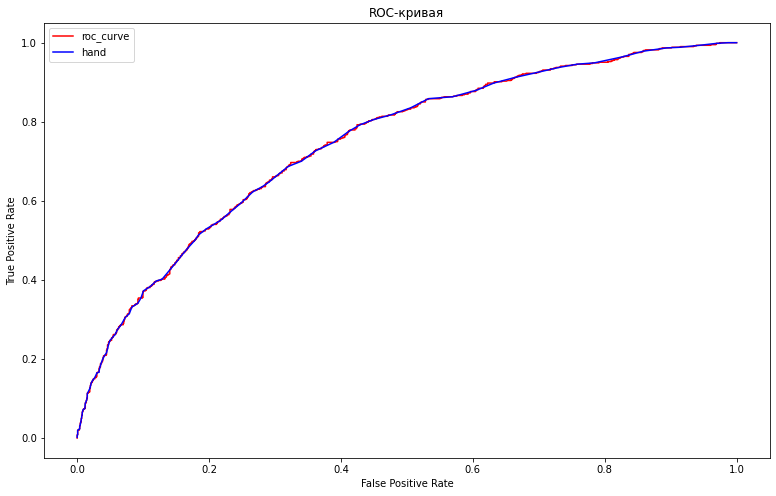

In [82]:
### Строим график ROC-кривой для "ручного" и машинного подсчёта fpr & tpr

plt.subplots(figsize = (13, 8))
plt.title(label='ROC-кривая')
plt.plot(fpr, tpr, 'r', label='roc_curve')
plt.plot( fpr2, tpr2, 'b', label='hand')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [83]:
from sklearn.metrics import auc    ### Площадь под кривой
auc(fpr, tpr), auc(fpr2, tpr2)

(0.7451629176618145, 0.7453443517114857)

### Построить график Precision - Recall на этих же данных.

In [84]:
from sklearn.metrics import precision_recall_curve
pr, re, thres = precision_recall_curve( Y_test, predictions[:, 1] )

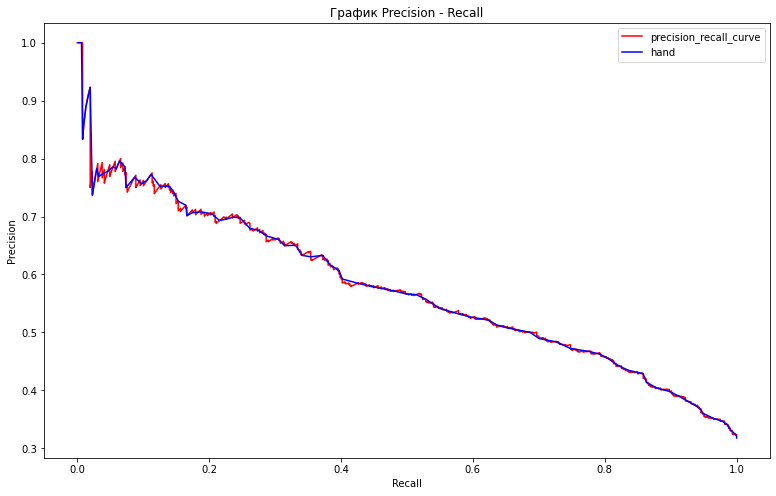

In [85]:
plt.subplots(figsize = (13, 8))
plt.title(label='График Precision - Recall')
plt.plot(re, pr, 'r', label='precision_recall_curve')
plt.plot( tpr2, prec, 'b', label='hand')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

In [86]:
from sklearn.metrics import average_precision_score

In [87]:
average_precision_score( Y_test, predictions[:, 1] )    ### Площадь под кривой

0.5761329928884336